<a href="https://colab.research.google.com/github/Camouflage10/RL-stocks/blob/main/get_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
!pip install yfinance
import yfinance as yf
import tensorflow as tf
import datetime
import math
import random
n=60
lookAhead=24

     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


1. set up game given 60 values guess buy or sell
2. graphing each step and wait for answer
3. setup a NN that catagorizes the state
4. setup RL model with the NN output plugiung in the states
5. optimize models

In [2]:
def getData(code, period, interval):
  df=yf.download(code,period=period,interval=interval)
  return df
data=getData("AAPL",'3mo','1h')
#normalize data between min max
data.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                                  Open        High         Low       Close  \
2022-02-14 09:30:00-05:00  167.369995  169.000000  167.089996  168.419998   
2022-02-14 10:30:00-05:00  168.429901  169.169998  167.699997  168.990005   
2022-02-14 11:30:00-05:00  169.000000  169.339996  168.470001  169.330002   
2022-02-14 12:30:00-05:00  169.315002  169.580002  168.850098  168.959000   
2022-02-14 13:30:00-05:00  168.964996  168.970001  166.559998  167.500000   
...                               ...         ...         ...         ...   
2022-05-11 15:30:00-04:00  146.570999  146.940002  145.809998  146.589996   
2022-05-12 09:30:00-04:00  142.770004  146.128098  140.091507  144.690002   
2022-05-12 10:30:00-04:00  144.690002  146.199997  143.649994  144.949997   
2022-05-12 11:30:00-04:00  144.949997  145.099792  143.880005  144.119995   
2022-05-12 11:35:33-04:00  144.190002  144.190002  144.190002  144.190002   

                            Adj Close    Volu

#1.linear reg the next n values and in the y=mx+b the m will be the state
#2. research different shapes and the states are defined as those shapes


In [3]:
def squeezeData(batch):#gets batch between 0-1
  min=np.amin(batch)
  max=np.amax(batch)
  for j in range(len(batch)):#scale from 0-1
    batch[j] = (batch[j]-min)/(max-min)
  return batch

In [4]:
#linear reg stateData
from sklearn.linear_model import LinearRegression
def regLookAhead(stateData,lookAhead):#takes in lookAhead number and data and outs a linear model
  x=np.array([i for i in range(lookAhead)]).reshape(-1,1)
  labely=stateData
  #add hyper param
  reg = LinearRegression()
  reg.fit(x, labely)
  #reg.coef_
  return reg

In [5]:
def giveState(reg):
  x=reg.coef*3+6
  if x<0:
    return 0
  if x>12:
    return 12
  return int(x)

In [6]:
def preprocessing(df,n,lookAhead):
  df=df.filter(['Adj Close'])
  df=df.values
  X=[]
  y=[]
  stateData=[]
  for i in range(n,len(df)-(n+lookAhead)):
    preBatch=df[i-n:i,0]
    batch=preBatch.copy()
    batch=squeezeData(batch)
    X.append(batch)#first n val scaled
    stateData=df[i:i+lookAhead,0]#next lookAhead values
    reg=regLookAhead(stateData,lookAhead)
    #append state or coef and %diff of last val and y intercept
    state=[reg.coef_]
    y.append(state)
  return X,y

In [7]:
def multiPreprocessing(df,n,lookAhead):
  X=[]
  y=[]
  for d in df:
    d=d.filter(['Adj Close'])
    d=d.values
    stateData=[]
    for i in range(n,len(d)-(n+lookAhead)):
      preBatch=d[i-n:i,0]
      batch=preBatch.copy()
      batch=squeezeData(batch)
      X.append(batch)#first n val scaled
      stateData=d[i:i+lookAhead,0]#next lookAhead values
      reg=regLookAhead(stateData,lookAhead)
      #append state or coef and %diff of last val and y intercept
      state=[reg.coef_]
      y.append(state)
  return X,y

In [8]:
data=getData('AAPL','1y','1h')
df=[]
stocks=['AAPL','TSLA']
for stock in stocks:
  df.append(getData(stock,'1y','1h'))
X,y=preprocessing(data,n,lookAhead)
batch=X[0]
testy=y[0]
print(batch)
print(testy)
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(len(X_train))
print(len(y_train))
X_trainS=tf.stack(X_train)
y_trainS=tf.stack(y_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[0.06837619 0.07527091 0.00759752 0.         0.06647645 0.56790089
 0.48622941 0.5887937  0.4339974  0.55840509 0.56980064 0.46915493
 0.74263941 0.77490893 0.8433054  0.90313349 0.91927766 0.93352355
 0.94396995 0.65147212 0.64957238 0.62081687 0.55623872 0.56220312
 0.57948772 0.7217466  0.80679878 0.78442502 0.74738804 0.73029471
 0.65147212 0.58349442 0.45204132 0.24501445 0.24343785 0.31908841
 0.33810032 0.42733164 0.39453031 0.4216527  0.74074112 0.81671338
 0.82431089 0.90883126 0.93449153 0.99335163 0.91927766 0.77112973
 0.64957238 0.61443513 0.60778677 0.61063565 0.66001878 0.56220312
 0.96106328 0.95726524 0.94778682 0.97135753 1.         0.99620052]
[array([-0.06649973])]
1138
1138


In [9]:
#3 have it auto label data
#study the data and define states
#normalize data between min max of the batch 0 1
#import karas
#get batch-60 of data
#label the data with the state that we want to predict
#7,5, or increase-linereg
#10-20 states for -shaperecog
# input 60 compare 1-3 hidden layers, output #states values between 0-1, play with different activation fuctions
!pip install -q -U keras-tuner
import keras_tuner as kt
#start nodes, array of ints for lstm, array of ints for dense, act, dropout
def lstmModel(inputShape=(len(X_train[0]),1),start=60,rate=.5,layers=3, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  nodes=start*rate
  #input
  model.add(LSTM(120, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(start,return_sequences=False))
  model.add(Dense(nodes,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

     |████████████████████████████████| 133 kB 3.5 MB/s 


In [10]:
def lstmModel2(inputShape=(len(X_train[0]),1),start=120,next=60,last=20, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  #input
  model.add(LSTM(start, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(next,return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(last,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

In [ ]:
from keras.backend import dropout
#gridsearch hyper parameters
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
mod = KerasClassifier(build_fn=lstmModel2)
param=dict(dropout=[None,.05,.08,.1], epochs=[10,20], start=[400,200,150],next=[200,100],last=[200,100])
grid = GridSearchCV(estimator=mod, param_grid=param, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3, refit=False)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
#{'dropout': 0.2, 'epochs': 50, 'layers': 2, 'rate': 0.1, 'start': 60}
#{'dropout': 0.1, 'epochs': 25, 'layers': 1, 'rate': 0.075, 'start': 50}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """


{'dropout': None, 'epochs': 10, 'last': 200, 'next': 200, 'start': 400}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
288 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 234, in fit
    raise ValueError('Invalid shape for y: ' + str(y.shape))
ValueError: Invalid shape for y: (758, 1, 1)

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mode

In [11]:
#make models
models=[]
models.append(lstmModel((len(X_train[0]),1),80,.5,4,dropout=.5))
models.append(lstmModel2())
for model in models:
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 120)           58560     
                                                                 
 lstm_1 (LSTM)               (None, 80)                64320     
                                                                 
 dense (Dense)               (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 126,161
Trainable params: 126,161
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)              

In [28]:
#fit
batch_size=200
histories=[]
for model in models:
  print('model')
  histories.append(model.fit(X_trainS,y_trainS, epochs=10, batch_size=batch_size, validation_split=0.1))

model
Epoch 1/10
6/6 [==============================] - 4s 588ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 2/10
6/6 [==============================] - 2s 400ms/step - loss: 0.0205 - val_loss: 0.0213
Epoch 3/10
6/6 [==============================] - 2s 389ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 4/10
6/6 [==============================] - 2s 397ms/step - loss: 0.0220 - val_loss: 0.0273
Epoch 5/10
6/6 [==============================] - 2s 393ms/step - loss: 0.0257 - val_loss: 0.0216
Epoch 6/10
6/6 [==============================] - 2s 384ms/step - loss: 0.0226 - val_loss: 0.0222
Epoch 7/10
6/6 [==============================] - 2s 385ms/step - loss: 0.0233 - val_loss: 0.0235
Epoch 8/10
6/6 [==============================] - 2s 376ms/step - loss: 0.0224 - val_loss: 0.0223
Epoch 9/10
6/6 [==============================] - 2s 383ms/step - loss: 0.0211 - val_loss: 0.0184
Epoch 10/10
6/6 [==============================] - 2s 375ms/step - loss: 0.0191 - val_loss: 0.0205
model
Epoch 1

In [14]:
#pred and error- model eval
def eval(name,model,hist):
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  print(name)
  epoches=pd.DataFrame(hist)
  plt.figure(0)
  plt.plot(epoches,label=name)
  plt.xlabel('epoch')
  plt.ylabel('loss/rmse')
  X_testS=tf.stack(X_test)
  pred=model.predict(X_testS)
  avgE=np.mean(np.absolute(pred-y_test))
  rmse=np.sqrt(np.mean(np.absolute(pred-y_test)**2))
  print('avg error: '+str(avgE))
  print('rmse: '+str(rmse))
  error=pred-y_test
  error=error.reshape(error.shape[0]*error.shape[1],1)
  error.shape
  plt.figure(1)
  plt.hist(error, bins='auto',label=name)
  plt.axvline(x=0.1,lw=1.3, color='g')
  plt.axvline(x=-0.1, lw=1.3, color='g')
  plt.title('error dist')
  plt.xlabel('error')
  plt.ylabel('count')
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  return fig1, fig2


model 0
avg error: 0.22150472299039112
rmse: 0.2790939791527965
model 1
avg error: 0.17555413262189065
rmse: 0.22444484954090327


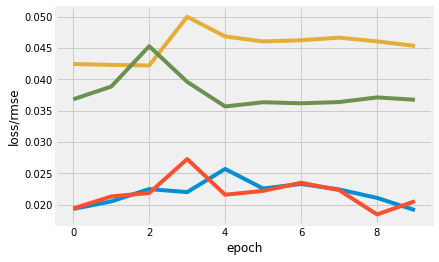

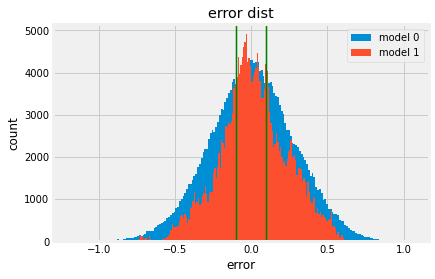

In [29]:
for i in range(len(models)):
  eval('model '+str(i),models[i], histories[i].history)

plt.legend()
plt.show()

In [ ]:
#setup RL with a max of 10 states and defines score by increasing value of money+stockval
